In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import scipy.stats as st
import matplotlib
import pickle
import scipy
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def get_exp(scale = 1.0, epochs = 15, N = [200, 100], reg_coeff = 0.0005):
    # scaling the architecture up/down
    #N = [int(t * scale) for t in N]
    N = [int(N[0] * scale), N[1]]

    def get_p_arr(p):
        """ p array with failure on the first layer """
        return [0, p]  + [0] * len(N)

    # Lips. coeff
    KLips = 1.

    # activation function
    activation = 'sigmoid'

    # training the network
    exp = MNISTExperiment(N = N, p_inference = get_p_arr(0), p_train = get_p_arr(0),
                          KLips = KLips, epochs = epochs,
                          activation = activation, reg_type = 'continuous',
                          reg_coeff = reg_coeff, do_print = 'plot',
                          name = 'experiment_weights', seed = None, batch_size = 1000)
    
    # returning the weights in the middle
    return exp

In [19]:
def get_activation_profile(exp, input_idx = 0, plot = True):
    """ Get a smooth activation profile """

    # obtaining the model
    m = exp.model_correct

    # obtaining the tf session
    sess = get_session()

    #print(exp.history.history)

    # some input
    x = exp.x_train[input_idx:input_idx + 1]
    #x = np.random.randn(1, *exp.x_train[0].shape)

    # obtaining the activation profile
    out1 = sess.run(m.layers[0].output, feed_dict = {m.input: x})

    if plot:
        # plotting the activation profile
        plt.figure(figsize=(10, 3))
        plt.plot(out1[0])
        plt.ylabel('$y_i$')
        plt.xlabel('$i_1=1..n_1$')
        plt.ylim((0,1))
        plt.show()
        
    
    print('val  _acc=%.2f' % exp.history.history['val_categorical_accuracy'][-1])
    print('train_acc=%.2f' % exp.history.history['categorical_accuracy'][-1])
    print('val  _loss=%.2f' % exp.history.history['val_loss'][-1])
    print('train_loss=%.2f' % exp.history.history['loss'][-1])

    # showing the regularization output
    #print("int [W'_{t_1}(t_1,t_0)]=%.2f" % sess.run(Continuous()(exp.W[0].T)))
    
    return out1[0]

In [ ]:
profiles = []
for _ in range(10):
    profile = get_activation_profile(get_exp())
    profiles.append(profile)

In [ ]:
# saving data
np.savetxt('WeightDistribution-Continuity-FC-MNIST-Layer1-Activations.txt', profiles)

In [22]:
def get_W_profile(**kwargs):
    """ Get a W[1] """
    # obtaining the experiment object
    exp = get_exp(**kwargs)
    
    profile = get_activation_profile(exp, plot = True)
    sess = get_session()
    print("int [W'_{t_1}(t_1,t_0)]=%.2f" % sess.run(Continuous(beta=1)(exp.W[0].T)))
    print('Biases: %.2f' % np.linalg.norm(exp.B[0]))
    result = (exp.W[1], profile)
    
    distr = result[0].flatten()
    print('MeanAbsW, StdAbsW', np.mean(np.abs(distr)), np.std(np.abs(distr)))
    print('|W|_1=%.2f' % np.linalg.norm(result[0], ord = 1))
    #plt.hist(distr, alpha = 0.3)
    
    # next layer must have continuous inputs...
    return np.mean(np.abs(distr))
def process_scale(s):
    """ Run many repetitions for one scale """
    print("Scale = %.2f" % s)
    return [get_W_profile(scale = s, epochs = 5, reg_coeff = 1) for _ in range(repetitions)]

def process_all():
    """ Random variable with all results """
    return {scale: process_scale(scale) for scale in tqdm(scales)}

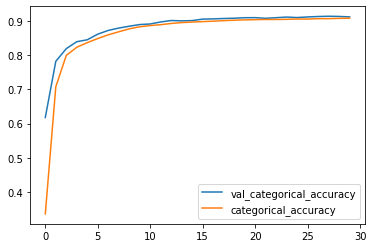

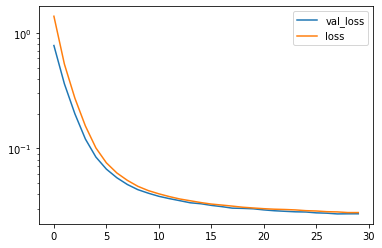

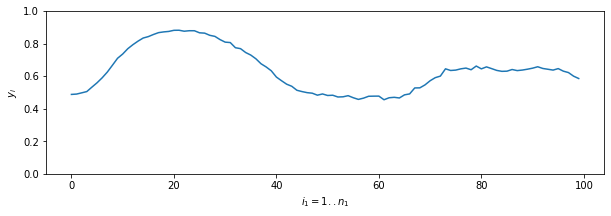

val  _acc=0.91
train_acc=0.91
val  _loss=0.03
train_loss=0.03
int [W'_{t_1}(t_1,t_0)]=8.28
Biases: 0.00
MeanAbsW, StdAbsW 0.124506064 0.09687972
|W|_1=15.28


In [30]:
r = get_W_profile(reg_coeff = 1e-3, epochs = 30, scale = 0.5)

In [31]:
# all scales of the network (up and down)
scales = np.linspace(0.5, 5, 5)

# repetitions for each scale
repetitions = 3

print('Total runs: %d' % (len(scales) * repetitions))

Total runs: 15


In [32]:
def process_scale(s):
    """ Run many repetitions for one scale """
    print("Scale = %.2f" % s)
    return [get_W_profile(scale = s, epochs = 15, reg_coeff = 1e-3) for _ in range(repetitions)]

def process_all():
    """ Random variable with all results """
    return {scale: process_scale(scale) for scale in tqdm(scales)}



  0%|          | 0/5 [00:00<?, ?it/s]

Scale = 0.50


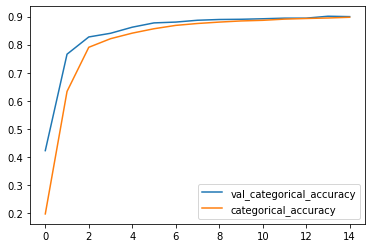

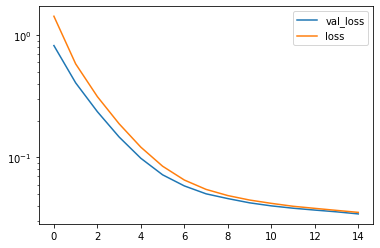

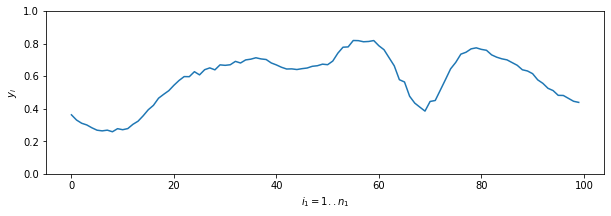

val  _acc=0.90
train_acc=0.90
val  _loss=0.03
train_loss=0.04
int [W'_{t_1}(t_1,t_0)]=10.56
Biases: 0.00
MeanAbsW, StdAbsW 0.12131716 0.092307046
|W|_1=16.27


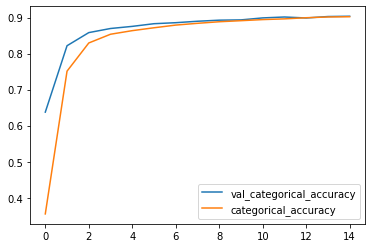

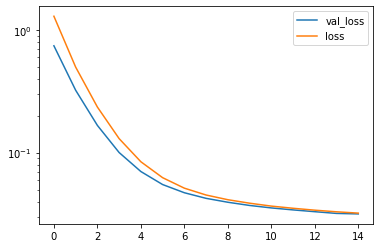

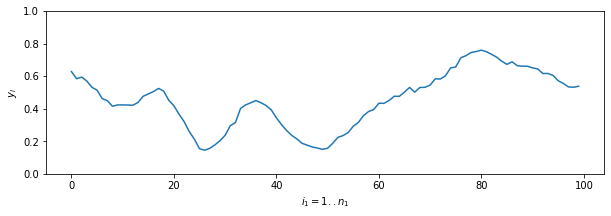

val  _acc=0.90
train_acc=0.90
val  _loss=0.03
train_loss=0.03
int [W'_{t_1}(t_1,t_0)]=9.98
Biases: 0.00
MeanAbsW, StdAbsW 0.12078375 0.093007
|W|_1=14.21


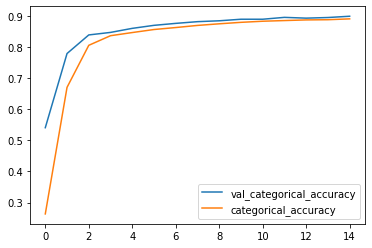

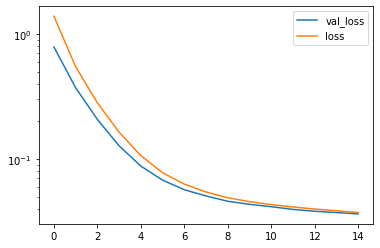

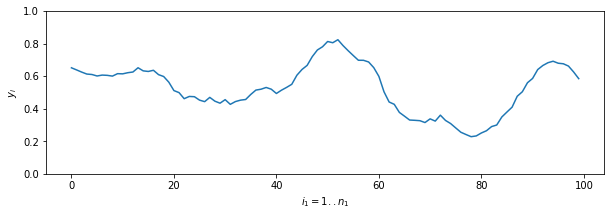

val  _acc=0.90
train_acc=0.89
val  _loss=0.04
train_loss=0.04




 20%|██        | 1/5 [00:39<02:37, 39.26s/it]

int [W'_{t_1}(t_1,t_0)]=11.33
Biases: 0.00
MeanAbsW, StdAbsW 0.12223605 0.09238761
|W|_1=14.80
Scale = 1.62


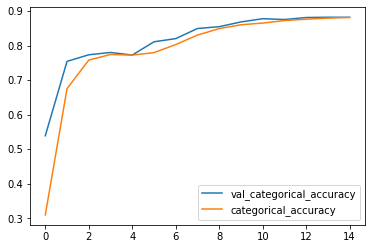

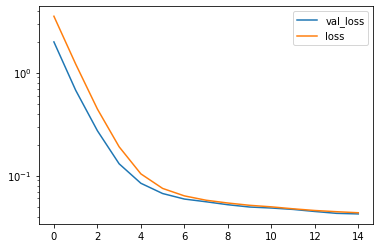

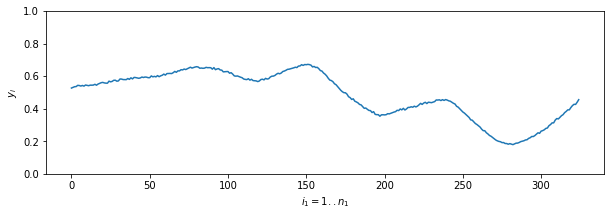

val  _acc=0.88
train_acc=0.88
val  _loss=0.04
train_loss=0.04
int [W'_{t_1}(t_1,t_0)]=15.42
Biases: 0.00
MeanAbsW, StdAbsW 0.06583056 0.050184224
|W|_1=8.14


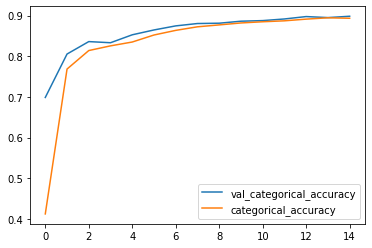

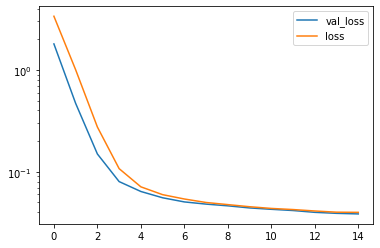

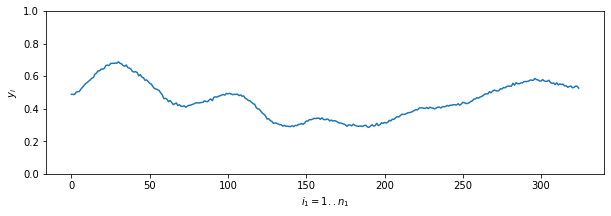

val  _acc=0.90
train_acc=0.89
val  _loss=0.04
train_loss=0.04
int [W'_{t_1}(t_1,t_0)]=15.48
Biases: 0.00
MeanAbsW, StdAbsW 0.0662153 0.050338443
|W|_1=8.17


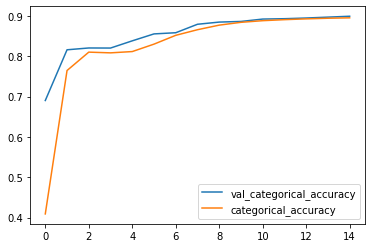

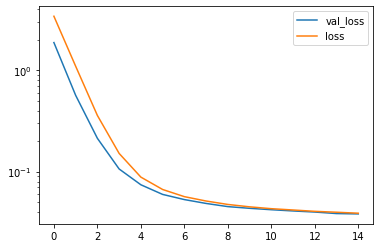

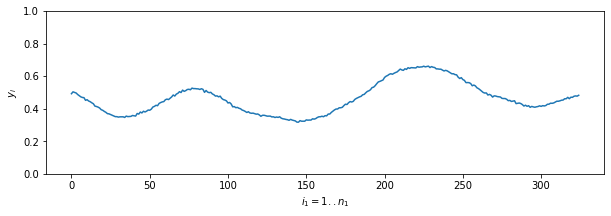

val  _acc=0.90
train_acc=0.90
val  _loss=0.04
train_loss=0.04




 40%|████      | 2/5 [01:25<02:04, 41.45s/it]

int [W'_{t_1}(t_1,t_0)]=15.50
Biases: 0.00
MeanAbsW, StdAbsW 0.06684145 0.05146582
|W|_1=8.43
Scale = 2.75


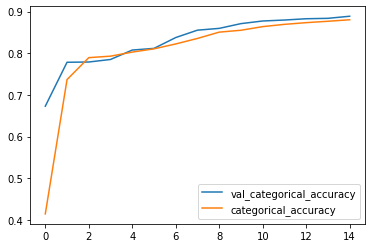

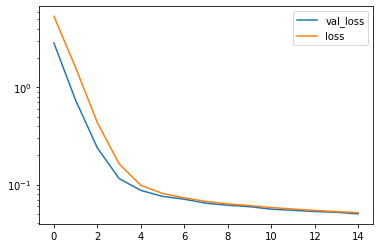

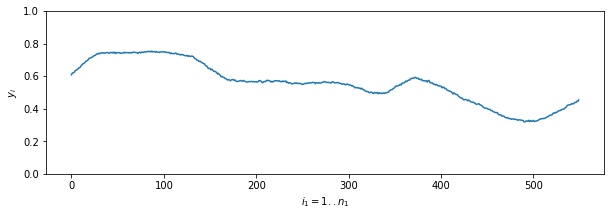

val  _acc=0.89
train_acc=0.88
val  _loss=0.05
train_loss=0.05
int [W'_{t_1}(t_1,t_0)]=21.49
Biases: 0.00
MeanAbsW, StdAbsW 0.050096672 0.03810626
|W|_1=6.20


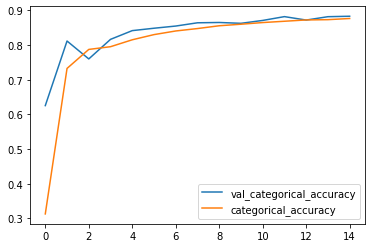

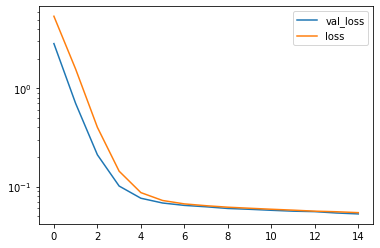

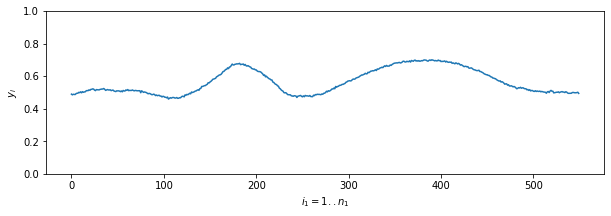

val  _acc=0.88
train_acc=0.88
val  _loss=0.05
train_loss=0.05
int [W'_{t_1}(t_1,t_0)]=21.82
Biases: 0.00
MeanAbsW, StdAbsW 0.050112095 0.038122293
|W|_1=6.31


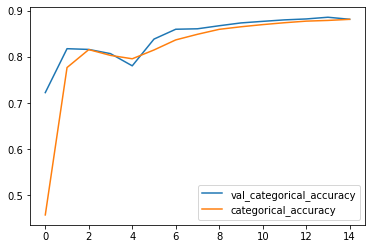

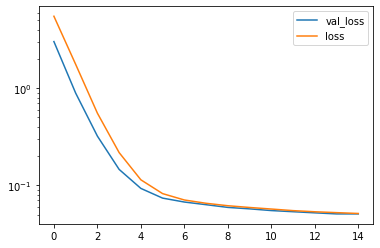

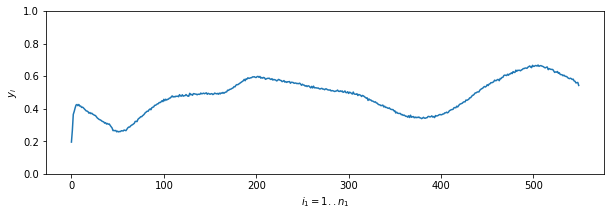

val  _acc=0.88
train_acc=0.88
val  _loss=0.05
train_loss=0.05




 60%|██████    | 3/5 [02:23<01:32, 46.27s/it]

int [W'_{t_1}(t_1,t_0)]=22.51
Biases: 0.00
MeanAbsW, StdAbsW 0.050587293 0.038430143
|W|_1=7.06
Scale = 3.88


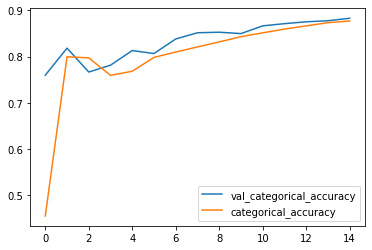

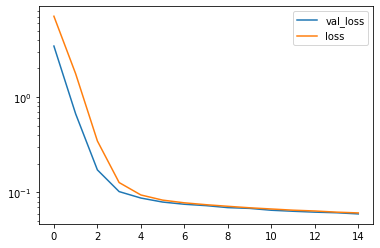

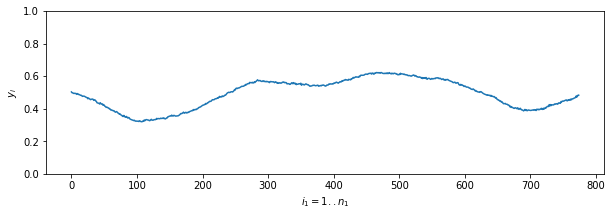

val  _acc=0.88
train_acc=0.88
val  _loss=0.06
train_loss=0.06
int [W'_{t_1}(t_1,t_0)]=28.21
Biases: 0.00
MeanAbsW, StdAbsW 0.042072415 0.032013558
|W|_1=5.17


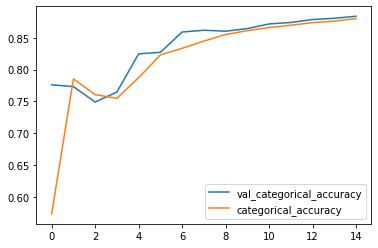

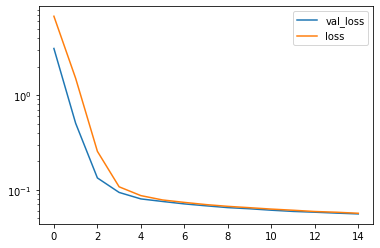

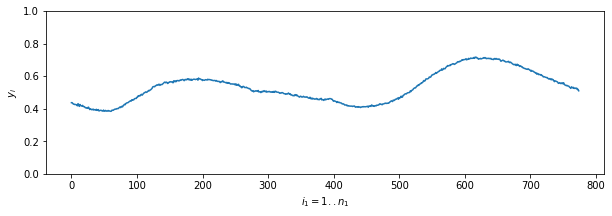

val  _acc=0.88
train_acc=0.88
val  _loss=0.06
train_loss=0.06
int [W'_{t_1}(t_1,t_0)]=28.22
Biases: 0.00
MeanAbsW, StdAbsW 0.042057518 0.031946726
|W|_1=5.16


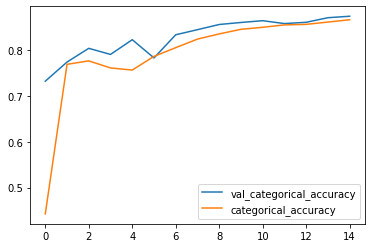

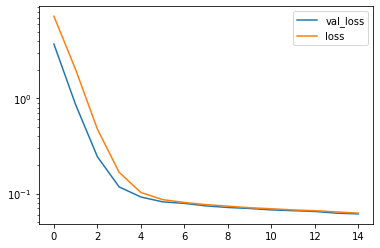

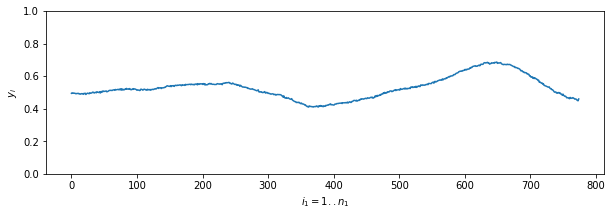

val  _acc=0.87
train_acc=0.87
val  _loss=0.06
train_loss=0.06




 80%|████████  | 4/5 [03:32<00:53, 53.08s/it]

int [W'_{t_1}(t_1,t_0)]=28.20
Biases: 0.00
MeanAbsW, StdAbsW 0.04207885 0.032084417
|W|_1=5.26
Scale = 5.00


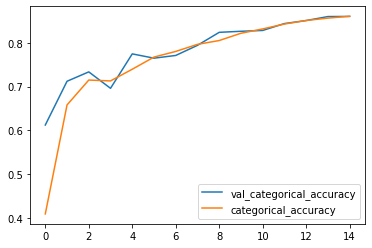

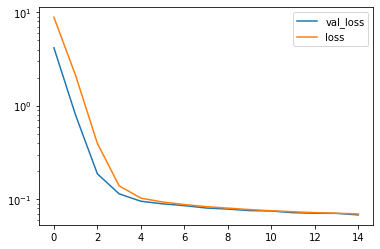

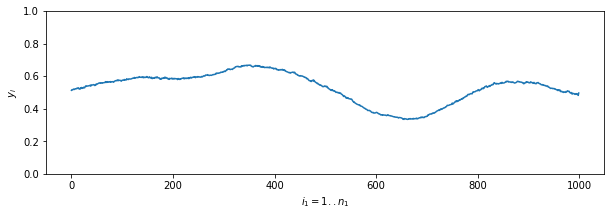

val  _acc=0.86
train_acc=0.86
val  _loss=0.07
train_loss=0.07
int [W'_{t_1}(t_1,t_0)]=34.50
Biases: 0.00
MeanAbsW, StdAbsW 0.03690681 0.028005969
|W|_1=4.66


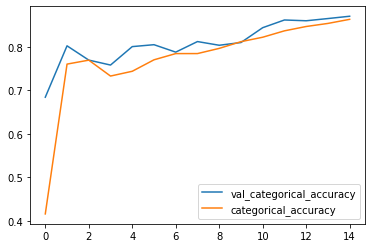

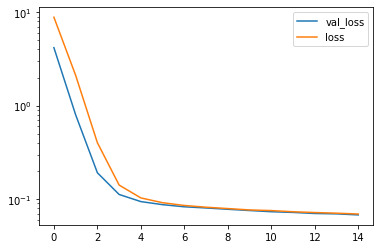

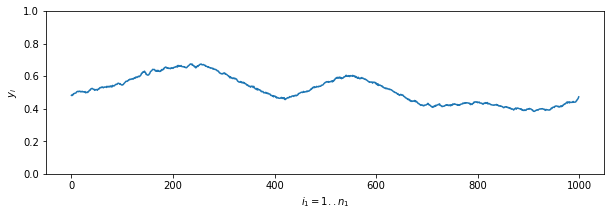

val  _acc=0.87
train_acc=0.86
val  _loss=0.07
train_loss=0.07
int [W'_{t_1}(t_1,t_0)]=34.87
Biases: 0.00
MeanAbsW, StdAbsW 0.037247475 0.028374828
|W|_1=4.66


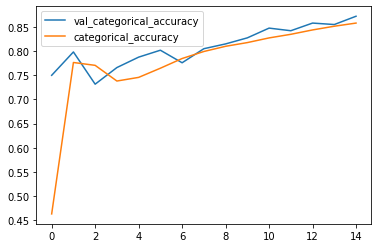

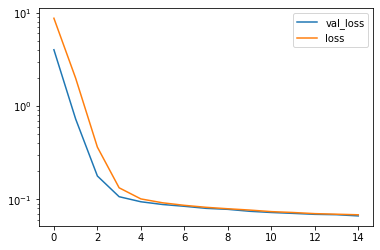

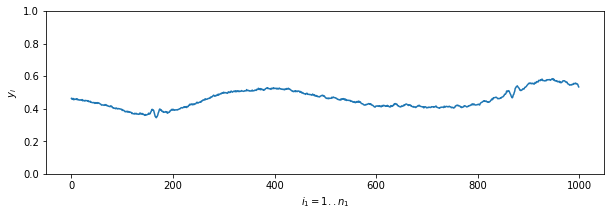

val  _acc=0.87
train_acc=0.86
val  _loss=0.07
train_loss=0.07




100%|██████████| 5/5 [04:50<00:00, 58.17s/it]

int [W'_{t_1}(t_1,t_0)]=35.26
Biases: 0.00
MeanAbsW, StdAbsW 0.037331473 0.028486412
|W|_1=4.84


In [145]:
# obtaining the results
results = process_all()

In [33]:
results={0.5: [0.12131716, 0.12078375, 0.12223605],
 1.625: [0.06583056, 0.0662153, 0.06684145],
 2.75: [0.050096672, 0.050112095, 0.050587293],
 3.875: [0.042072415, 0.042057518, 0.04207885],
 5.0: [0.03690681, 0.037247475, 0.037331473]}


In [25]:
pickle.dump(results, open('WeightDistribution-Continuity-FC-MNIST.pkl', 'wb'))

In [35]:
xs = sorted(list(results.keys()))
ys = [np.mean(results[x]) for x in xs]

In [36]:
def hyperbola(x, a):
    return 1. * a / x
hyperbola_coeff = curve_fit(hyperbola, xs, ys)[0][0]

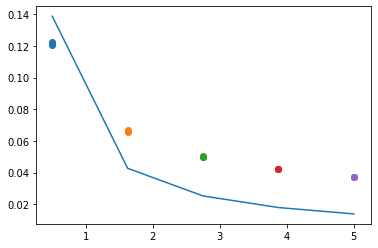

In [37]:
# trained 20 epochs
for scale in scales:
#    plt.figure()
    plt.scatter([scale] * repetitions, results[scale], )
plt.plot(xs, hyperbola_coeff / xs)
#    plt.show()

In [38]:
# There is a decay but it's not that strong

# Old notes

1. Method 1 (current): continuous regularization, 2nd layer matrix
1.  Method 2: L1 input, balanced neurons 1 layer

1.  old 1/n_l^2 coeff in front
1.  coeff=0.001,0.01,0.1,1,10 -> too big change, no continuity
1.  coeff=10 accuracy 0.9 some regularity, coeff=100
1.  added biases, removed 1/n_l scaling -> 0.001 gives a smooth activation profile!

1.  added biases, fixed 1/n_l
1. # 0.0001 too small, 0.001 accuracy decr -> 0.0005
1.  trying with increased scale... repeat
1.  trying with increased scale... they are different...

1.  Exactly the same decay without regularization...
1.  see bitbucket issue, need refactoring...
1.  idea: L1C at all layers???

### Analysis
Weights become smaller as scale grows.
There IS initial decay but it becomes smaller
Hypothesis: there is a problem with the coefficient
Solution: plot activation profiles as well
DONE

### Step 1
Profiles look too random? Need a bigger coeff? what if it's 1? is it fault-tolerant? are weights small?
L1 norms are decreasing 0.0005 -> weird profiles with higher N, seems normalization is not working well
WE NEED TO ADD EXPLICIT NORMALIZATION AS WELL!!!
removed bias

## Step 2
high coefff leads to oscill??? why??? plot range error? No, too small convolution window?. Using convolution with various filters -> better!
Tried Adam, set biases to 0
Some weird stuff with regularization.

### No regularization

In [39]:
def process_scale(s):
    """ Run many repetitions for one scale """
    print("Scale = %.2f" % s)
    return [get_W_profile(scale = s, epochs = 15, reg_coeff = 0) for _ in range(repetitions)]

def process_all():
    """ Random variable with all results """
    return {scale: process_scale(scale) for scale in tqdm(scales)}


  0%|          | 0/5 [00:00<?, ?it/s]

Scale = 0.50


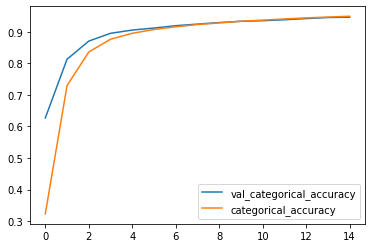

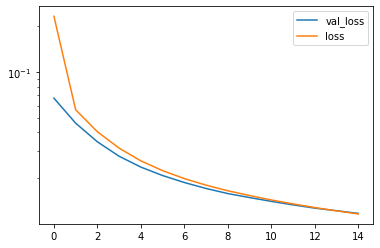

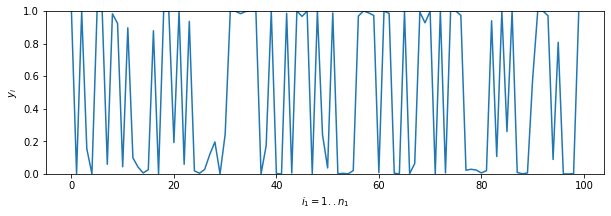

val  _acc=0.95
train_acc=0.95
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=1924.15
Biases: 0.00
MeanAbsW, StdAbsW 0.119089685 0.09338238
|W|_1=14.58


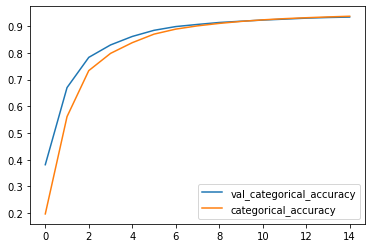

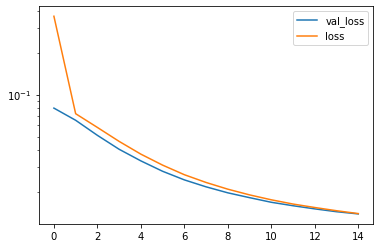

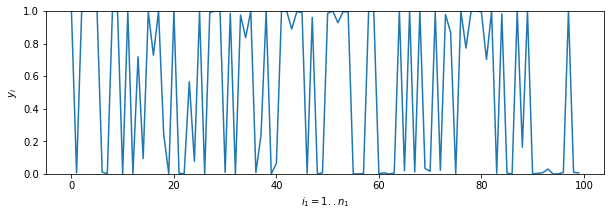

val  _acc=0.93
train_acc=0.94
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=1907.72
Biases: 0.00
MeanAbsW, StdAbsW 0.11716966 0.0907581
|W|_1=14.16


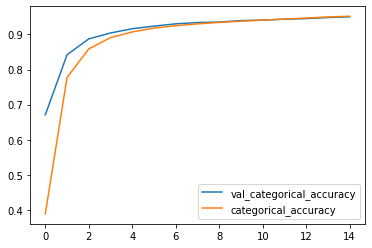

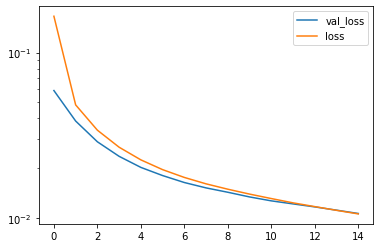

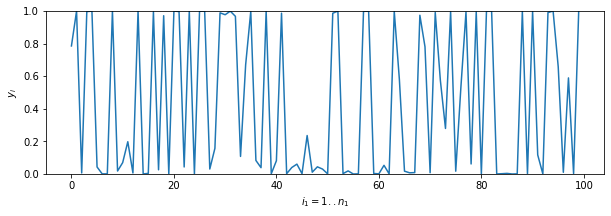


 20%|██        | 1/5 [00:19<01:16, 19.13s/it]

val  _acc=0.95
train_acc=0.95
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=1933.34
Biases: 0.00
MeanAbsW, StdAbsW 0.1177536 0.09099207
|W|_1=14.70
Scale = 1.62


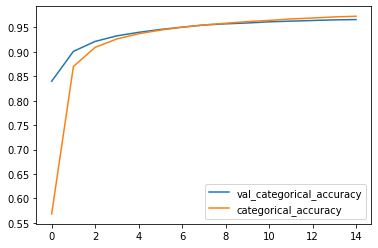

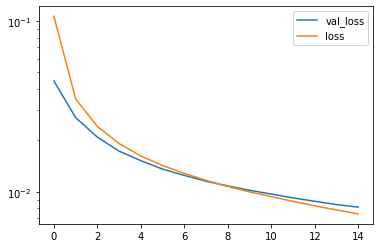

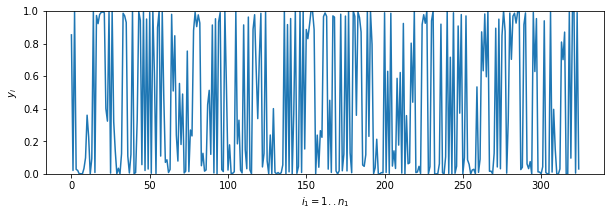

val  _acc=0.97
train_acc=0.97
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=5580.19
Biases: 0.00
MeanAbsW, StdAbsW 0.064832605 0.05052081
|W|_1=9.20


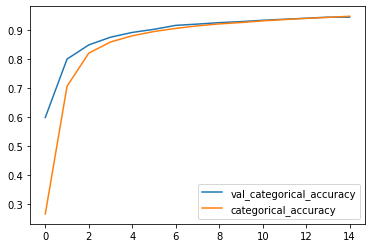

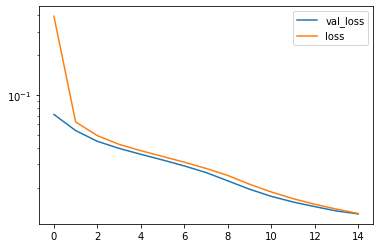

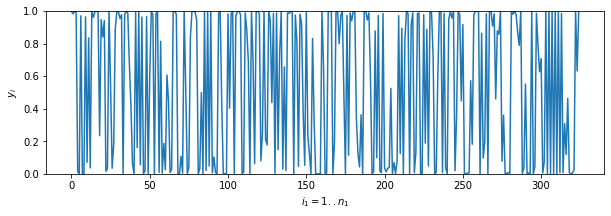

val  _acc=0.94
train_acc=0.95
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=5475.56
Biases: 0.00
MeanAbsW, StdAbsW 0.064510755 0.0498464
|W|_1=10.07


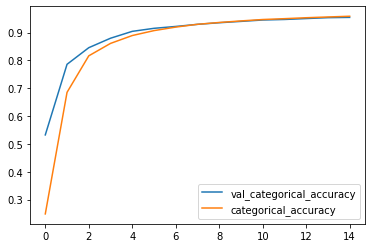

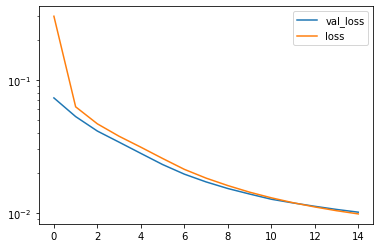

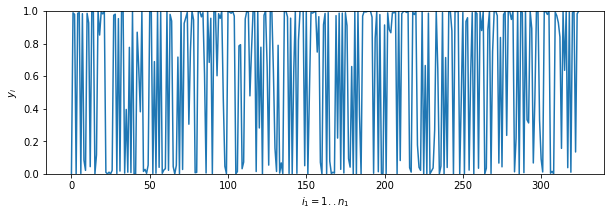


 40%|████      | 2/5 [00:40<00:59, 19.94s/it]

val  _acc=0.95
train_acc=0.96
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=5477.15
Biases: 0.00
MeanAbsW, StdAbsW 0.064643845 0.05060846
|W|_1=9.75
Scale = 2.75


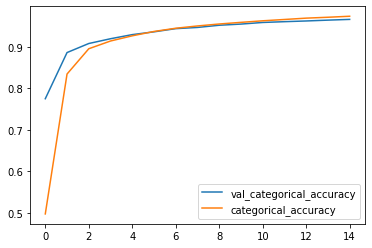

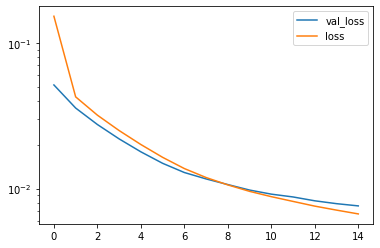

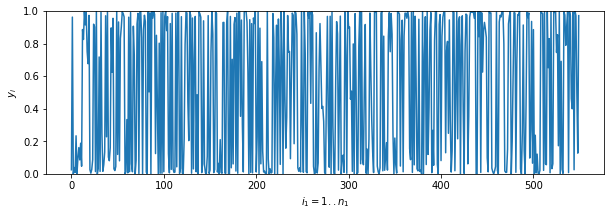

val  _acc=0.97
train_acc=0.97
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=8962.20
Biases: 0.00
MeanAbsW, StdAbsW 0.0502673 0.03921852
|W|_1=8.22


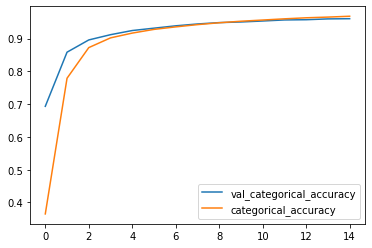

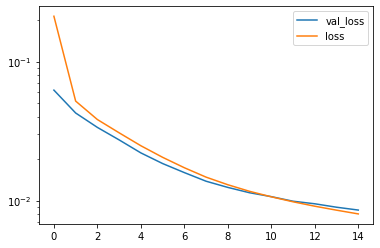

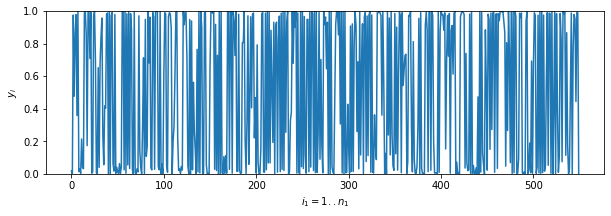

val  _acc=0.96
train_acc=0.97
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=8839.71
Biases: 0.00
MeanAbsW, StdAbsW 0.05059075 0.039927315
|W|_1=9.18


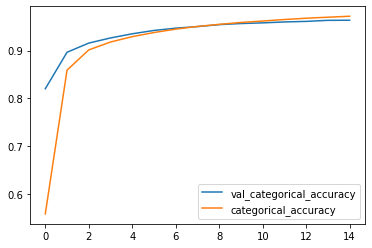

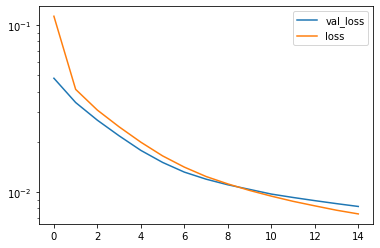

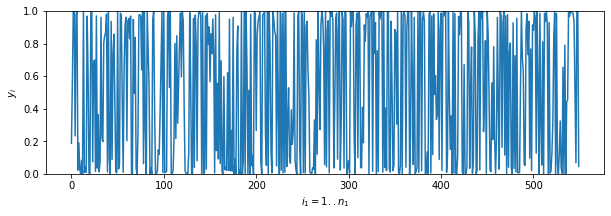

val  _acc=0.96
train_acc=0.97
val  _loss=0.01
train_loss=0.01



 60%|██████    | 3/5 [01:07<00:43, 21.93s/it]

int [W'_{t_1}(t_1,t_0)]=8978.37
Biases: 0.00
MeanAbsW, StdAbsW 0.0496167 0.03831805
|W|_1=8.54
Scale = 3.88


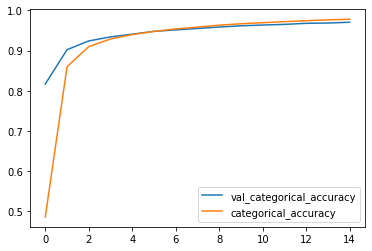

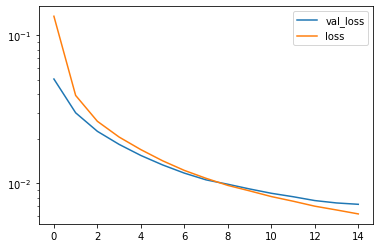

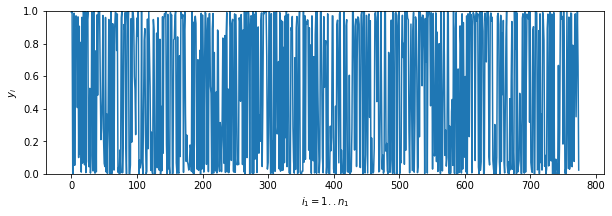

val  _acc=0.97
train_acc=0.98
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=12254.57
Biases: 0.00
MeanAbsW, StdAbsW 0.042354073 0.032805968
|W|_1=7.61


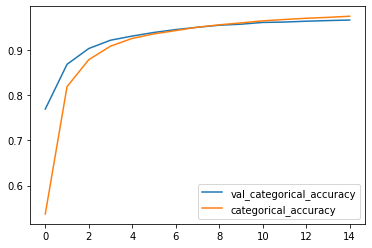

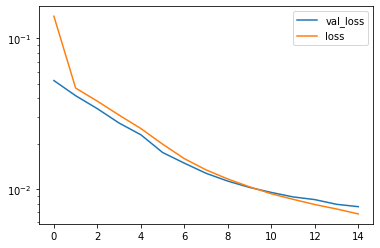

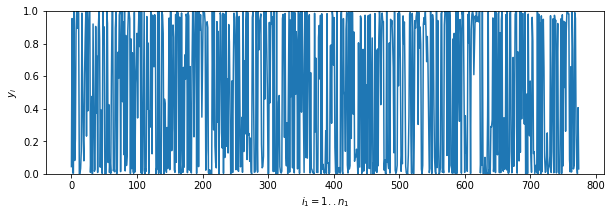

val  _acc=0.97
train_acc=0.97
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=12244.42
Biases: 0.00
MeanAbsW, StdAbsW 0.042193074 0.03274951
|W|_1=6.87


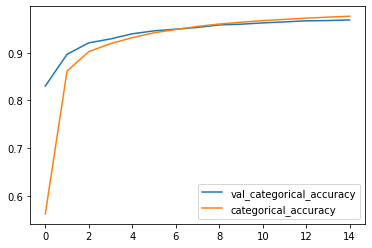

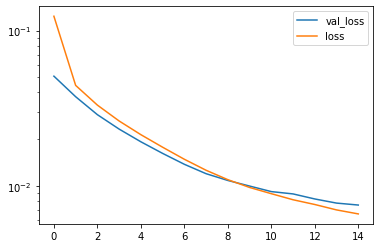

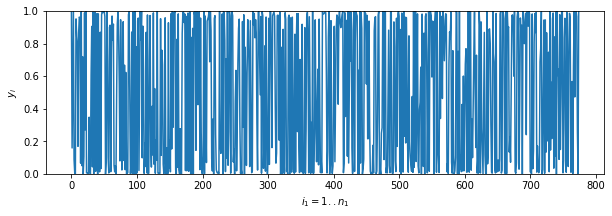

val  _acc=0.97
train_acc=0.98
val  _loss=0.01
train_loss=0.01



 80%|████████  | 4/5 [01:38<00:24, 24.53s/it]

int [W'_{t_1}(t_1,t_0)]=12267.96
Biases: 0.00
MeanAbsW, StdAbsW 0.041725002 0.032471366
|W|_1=7.36
Scale = 5.00


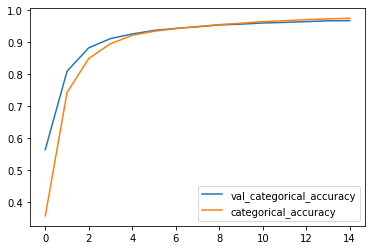

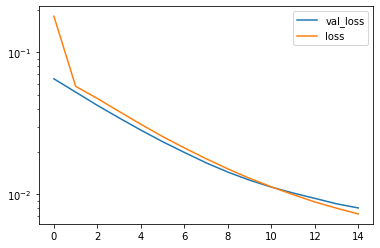

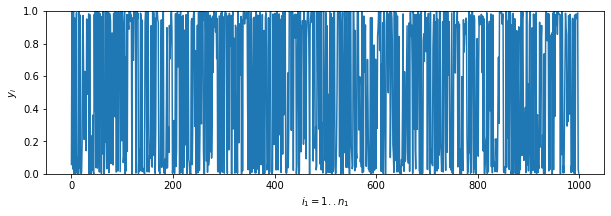

val  _acc=0.97
train_acc=0.98
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=15468.44
Biases: 0.00
MeanAbsW, StdAbsW 0.037159767 0.029099394
|W|_1=5.15


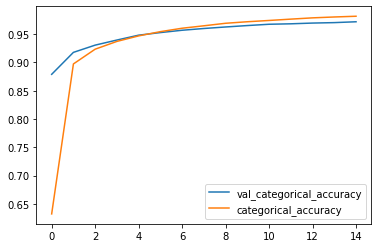

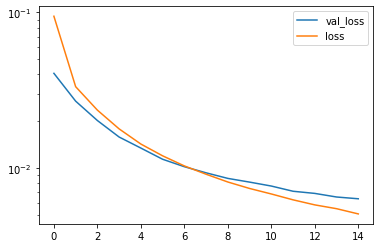

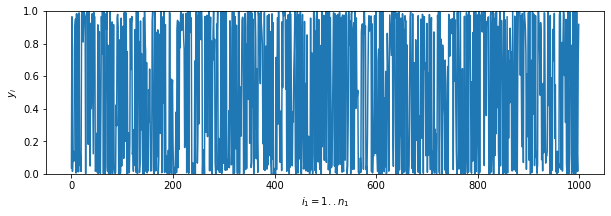

val  _acc=0.97
train_acc=0.98
val  _loss=0.01
train_loss=0.01
int [W'_{t_1}(t_1,t_0)]=15616.38
Biases: 0.00
MeanAbsW, StdAbsW 0.03728797 0.028957143
|W|_1=6.71


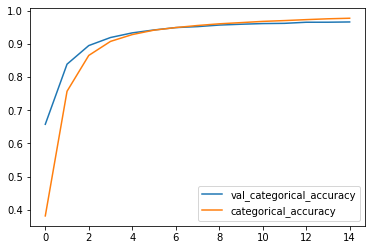

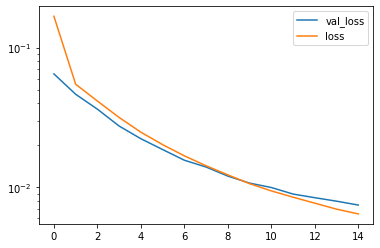

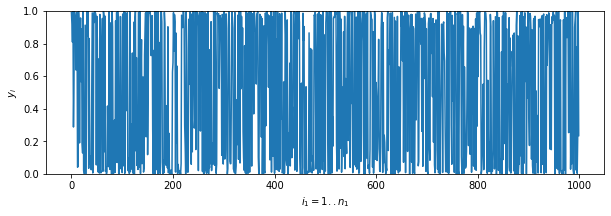

val  _acc=0.97
train_acc=0.98
val  _loss=0.01
train_loss=0.01



100%|██████████| 5/5 [02:14<00:00, 26.99s/it]

int [W'_{t_1}(t_1,t_0)]=15449.37
Biases: 0.00
MeanAbsW, StdAbsW 0.037065394 0.029067148
|W|_1=7.12


In [40]:
# obtaining the results
results = process_all()

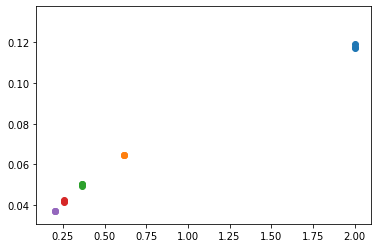

In [42]:
# trained 20 epochs
for scale in scales:
#    plt.figure()
    plt.scatter([1/scale] * repetitions, results[scale], )
#plt.plot(xs, hyperbola_coeff / xs)
#    plt.show()